### Common Task: HIGGS Dataset Classification with Transformer Autoencoder

**Dataset**:  
- **Source**: [UCI HIGGS Dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS)  
- Loaded via **Google Drive** from `HIGGS 2.csv.gz`  
- Used **first 1.1 million events** with **21 features + 1 label**

**Preprocessing**:
- Extracted label (column 0) and 21 features (columns 1–21)
- Converted to `float32` for PyTorch compatibility

---

### Solution Overview

- **Split**:
  - **Train**: 900k samples  
  - **Validation**: 100k samples  
  - **Test**: Final 100k samples (held out)  
  - Split done via `train_test_split` with `random_state=42` for reproducibility

- **Model Architecture**:  
  - **Encoder**: Transformer encoder maps 21 features into a latent vector  
  - **Decoder**: Feedforward classifier built on top of latent space  
  - Chosen for its ability to capture complex feature interactions using attention

- **Training Setup**:  
  - **Loss**:  
    - `FocalLoss` for class imbalance  
    - `SmoothBCE` with ε=0.1 for label smoothing  
  - **Optimizer**: `AdamW`  
  - **Scheduler**: `OneCycleLR`  
  - **Mixed Precision**: `torch.cuda.amp` + `GradScaler`  
  - **Early Stopping**: Based on validation ROC-AUC (patience = 3)

- **Training Tricks**:  
  - Label smoothing to reduce overconfidence  
  - OneCycleLR for adaptive learning rate control  
  - Gradient scaling for numerical stability

**Evaluation**:  
- ROC-AUC on validation set tracked per epoch  
- Best model checkpointed as `best_transformer_model.pt`  
- Final classifier tested on the 100k held-out samples  
- AUC-vs-Epoch curve plotted for visual inspection

---

### Notes

- Transformer models effectively handle structured tabular data through attention-based encoding  
- Latent representations from the encoder were leveraged for classification  
- This setup aims to benchmark performance against the [original HIGGS paper](https://arxiv.org/pdf/1402.4735.pdf)


In [ ]:

from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
import copy

# Mount Google Drive
drive.mount('/content/drive')

# Load Data
file_path = '/content/drive/MyDrive/Data/HIGGS 2.csv.gz'
df = pd.read_csv(file_path, compression='gzip')
df = df.iloc[:1_100_000, :22]  # 21 features + label

# Split features and label
X = df.iloc[:, 1:].values.astype(np.float32)
y = df.iloc[:, 0].values.astype(np.float32)

# Train-val-test split
X_trainval, X_test, y_trainval, y_test = X[:-100_000], X[-100_000:], y[:-100_000], y[-100_000:]
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=42)

# Convert to PyTorch tensors
def make_loader(X, y, batch_size=2048, shuffle=True):
    tensor_X = torch.tensor(X)
    tensor_y = torch.tensor(y)
    dataset = TensorDataset(tensor_X, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train)
val_loader = make_loader(X_val, y_val, shuffle=False)
test_loader = make_loader(X_test, y_test, shuffle=False)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-2981bf12d2ef>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 440/440 [00:51<00:00,  8.57it/s]


Epoch 1 - Loss: 0.0425 - Val AUC: 0.6544


Epoch 2:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2: 100%|██████████| 440/440 [00:50<00:00,  8.63it/s]


Epoch 2 - Loss: 0.0414 - Val AUC: 0.6927


Epoch 3:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3: 100%|██████████| 440/440 [00:50<00:00,  8.65it/s]


Epoch 3 - Loss: 0.0404 - Val AUC: 0.7109


Epoch 4:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4: 100%|██████████| 440/440 [00:49<00:00,  8.85it/s]


Epoch 4 - Loss: 0.0396 - Val AUC: 0.7375


Epoch 5:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5: 100%|██████████| 440/440 [00:49<00:00,  8.87it/s]


Epoch 5 - Loss: 0.0390 - Val AUC: 0.7443


Epoch 6:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6: 100%|██████████| 440/440 [00:50<00:00,  8.74it/s]


Epoch 6 - Loss: 0.0385 - Val AUC: 0.7507


Epoch 7:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7: 100%|██████████| 440/440 [00:51<00:00,  8.52it/s]


Epoch 7 - Loss: 0.0382 - Val AUC: 0.7602


Epoch 8:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8: 100%|██████████| 440/440 [00:50<00:00,  8.66it/s]


Epoch 8 - Loss: 0.0378 - Val AUC: 0.7641


Epoch 9:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9: 100%|██████████| 440/440 [00:50<00:00,  8.64it/s]


Epoch 9 - Loss: 0.0376 - Val AUC: 0.7680


Epoch 10:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10: 100%|██████████| 440/440 [00:51<00:00,  8.61it/s]


Epoch 10 - Loss: 0.0374 - Val AUC: 0.7706


Epoch 11:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11: 100%|██████████| 440/440 [00:50<00:00,  8.64it/s]


Epoch 11 - Loss: 0.0372 - Val AUC: 0.7755


Epoch 12:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12: 100%|██████████| 440/440 [00:49<00:00,  8.84it/s]


Epoch 12 - Loss: 0.0369 - Val AUC: 0.7800


Epoch 13:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13: 100%|██████████| 440/440 [00:51<00:00,  8.59it/s]


Epoch 13 - Loss: 0.0367 - Val AUC: 0.7820


Epoch 14:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14: 100%|██████████| 440/440 [00:51<00:00,  8.57it/s]


Epoch 14 - Loss: 0.0365 - Val AUC: 0.7862


Epoch 15:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15: 100%|██████████| 440/440 [00:50<00:00,  8.71it/s]


Epoch 15 - Loss: 0.0362 - Val AUC: 0.7890


Epoch 16:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16: 100%|██████████| 440/440 [00:51<00:00,  8.62it/s]


Epoch 16 - Loss: 0.0360 - Val AUC: 0.7918


Epoch 17:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17: 100%|██████████| 440/440 [00:50<00:00,  8.69it/s]


Epoch 17 - Loss: 0.0358 - Val AUC: 0.7929


Epoch 18:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18: 100%|██████████| 440/440 [00:51<00:00,  8.61it/s]


Epoch 18 - Loss: 0.0356 - Val AUC: 0.7947


Epoch 19:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19: 100%|██████████| 440/440 [00:51<00:00,  8.56it/s]


Epoch 19 - Loss: 0.0355 - Val AUC: 0.7953


Epoch 20:   0%|          | 0/440 [00:00<?, ?it/s]<ipython-input-8-2981bf12d2ef>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20: 100%|██████████| 440/440 [00:51<00:00,  8.58it/s]


Epoch 20 - Loss: 0.0354 - Val AUC: 0.7954


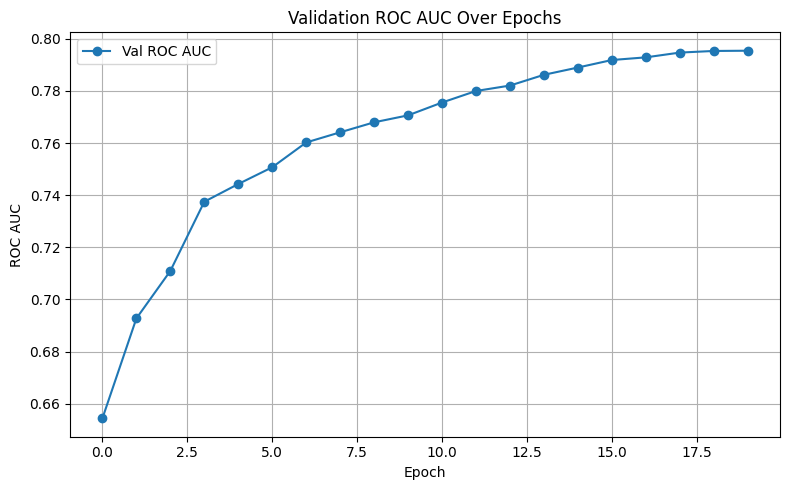


Best Validation AUC: 0.7954


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

# Label Smoothing
class SmoothBCE:
    def __init__(self, smoothing=0.1):
        self.smoothing = smoothing
    def __call__(self, targets):
        return targets * (1.0 - self.smoothing) + 0.5 * self.smoothing

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerAutoencoder().to(device)
criterion = FocalLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scaler = GradScaler()

# OneCycleLR
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, epochs=20, steps_per_epoch=steps_per_epoch,
    pct_start=0.3, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e4
)

# Hyperparams
label_smoother = SmoothBCE(0.1)
best_auc = 0
patience = 3
patience_counter = 0
best_model = None
val_auc_history = []
num_epochs = 20

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        xb, yb = xb.to(device), yb.to(device)
        yb_smooth = label_smoother(yb.float())  # Apply label smoothing

        optimizer.zero_grad()
        with autocast():
            preds = model(xb).squeeze()
            loss = criterion(preds, yb_smooth)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = torch.sigmoid(model(xb).squeeze()).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(yb.numpy())

    val_auc = roc_auc_score(val_labels, val_preds)
    val_auc_history.append(val_auc)
    print(f"Epoch {epoch+1} - Loss: {train_loss/len(train_loader):.4f} - Val AUC: {val_auc:.4f}")

    # Early Stopping
    if val_auc > best_auc:
        best_auc = val_auc
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
        torch.save(model.state_dict(), "best_transformer_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Combined AUC-vs-Epoch Plot
plt.figure(figsize=(8, 5))
plt.plot(val_auc_history, marker='o', label='Val ROC AUC')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.title("Validation ROC AUC Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Validation AUC: {best_auc:.4f}")


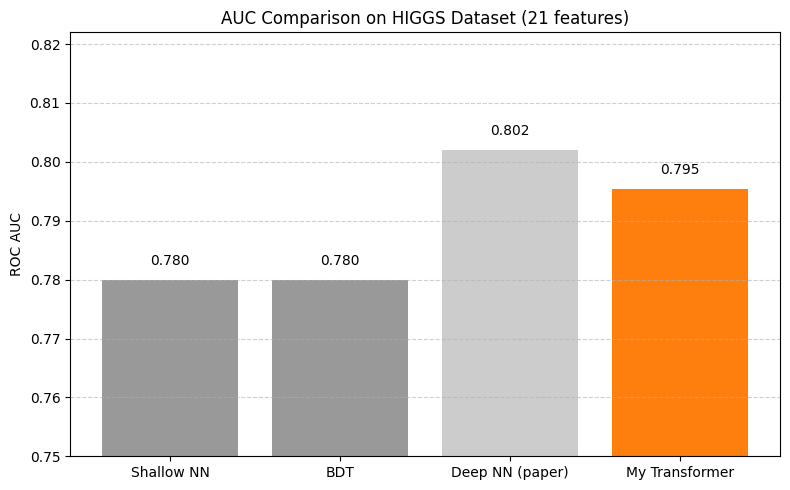

In [4]:
# AUCs from the paper for comparison
import matplotlib.pyplot as plt

baseline_models = ['Shallow NN', 'BDT', 'Deep NN (paper)', 'My Transformer']
baseline_aucs = [0.78, 0.78, 0.802, 0.7954]

colors = ['#999999', '#999999', '#cccccc', '#ff7f0e']

plt.figure(figsize=(8, 5))
bars = plt.bar(baseline_models, baseline_aucs, color=colors)
plt.ylim(0.75, max(baseline_aucs) + 0.02)
plt.ylabel('ROC AUC')
plt.title('AUC Comparison on HIGGS Dataset (21 features)')

# Annotate each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.3f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/higgs_transformer_model_optimised.pt"
torch.save(model.state_dict(), save_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
